# Add constant force

In [1]:
import molsysmt as msm

In [2]:
import openmm as mm
from openmm import unit
from openmm import app
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

In [3]:
molecular_system = msm.systems['Trp-Cage']['1l2y.h5msm']

In [4]:
topology = msm.convert(molecular_system, to_form='openmm.Topology')
positions = msm.get(molecular_system, element='atom', structure_indices=0, coordinates=True)
positions = msm.pyunitwizard.convert(positions[0], to_form='openmm.unit')

In [5]:
forcefield = app.ForceField("amber14-all.xml", "amber14/tip3p.xml")

In [6]:
system = forcefield.createSystem(topology, nonbondedMethod=app.NoCutoff, constraints=app.HBonds)

In [7]:
temperature = 300*unit.kelvin

In [8]:
integration_timestep = 2.0*unit.femtoseconds
saving_interval = 1.00*unit.picoseconds
logging_interval = 100.00*unit.picoseconds
simulation_time = 500.*unit.picoseconds

saving_steps = int(saving_interval/integration_timestep)
logging_steps = int(logging_interval/integration_timestep)
md_steps = int(simulation_time/integration_timestep)

In [9]:
friction   = 5.0/unit.picoseconds
integrator = mm.LangevinIntegrator(temperature, friction, integration_timestep)

In [10]:
platform = mm.Platform.getPlatformByName('OpenCL')

In [11]:
simulation = app.Simulation(topology, system, integrator, platform)

In [12]:
simulation.context.setPositions(positions)

In [13]:
msm.get(simulation, n_groups=True)

20

In [14]:
msm.info(simulation, element='atom', selection='group_index==0 and atom_type=="C"')

index,id,name,type,group index,group id,group name,group type,component index,chain index,molecule index,molecule type,entity index,entity name
1,2,CA,C,0,1,ASN,amino acid,0,0,0,peptide,0,None
2,3,C,C,0,1,ASN,amino acid,0,0,0,peptide,0,None
4,5,CB,C,0,1,ASN,amino acid,0,0,0,peptide,0,None
5,6,CG,C,0,1,ASN,amino acid,0,0,0,peptide,0,None


In [15]:
msm.info(simulation, element='atom', selection='group_index==19 and atom_type=="C"')

index,id,name,type,group index,group id,group name,group type,component index,chain index,molecule index,molecule type,entity index,entity name
293,294,CA,C,19,20,SER,amino acid,0,0,0,peptide,0,None
294,295,C,C,19,20,SER,amino acid,0,0,0,peptide,0,None
296,297,CB,C,19,20,SER,amino acid,0,0,0,peptide,0,None


In [16]:
msm.thirds.openmm.forces.pin_atoms(simulation, selection='group_index==0 and atom_name=="CA"')

5

In [17]:
msm.thirds.openmm.forces.add_constant_force(simulation, selection='group_index==19 and atom_name=="CA"',
                                            force = '[500,0,0] kilojoules/(mole*nanometer)')

6

In [18]:
reporter_tqdm = msm.thirds.openmm.reporters.TQDMReporter(logging_steps, md_steps, temperature=False)
simulation.reporters.append(reporter_tqdm)

In [19]:
reporter_trajectory_dict = msm.thirds.openmm.reporters.TrajectoryDictReporter(saving_steps, time=True, coordinates=True)
simulation.reporters.append(reporter_trajectory_dict)

In [20]:
simulation.step(md_steps)

  0%|          | 0/250000 [00:00<?, ?it/s]


Potential energy: -1714.79 kJ/mol ± 204.61 kJ/mol

Execution time: 0 days, 0 hours, 0 minutes, and 14.77 seconds (2924.449 ns/day).



In [22]:
trajectory_dict = reporter_trajectory_dict.finalize()

In [23]:
index_CA1, index_CA20 = msm.get(topology, element='atom', selection='group_index in [0,19] and atom_name=="CA"', atom_index=True)

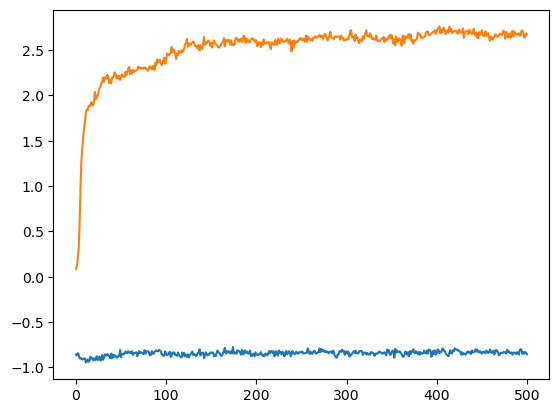

In [24]:
plt.plot(trajectory_dict['time'], trajectory_dict['coordinates'][:,index_CA1,0])
plt.plot(trajectory_dict['time'], trajectory_dict['coordinates'][:,index_CA20,0])

plt.show()

In [25]:
msm.view([topology, trajectory_dict])

NGLWidget(max_frame=500)